# UE 4268 - QISKIT Project 3

**`vos noms et prenoms`**, `matricule` et `email` 


Department of Physics - Faculty of Science - University of Yaoundé I

`Nom du Laboratoire`

`Date`

$$
\newcommand{\ket}[1]{|#1\rangle} 
\newcommand{\bk}[2]{\langle#1|#2\rangle.} %braket
\newcommand{\mt}[1]{\mathtt{#1}} 
%  
\newcommand{\X}{\mathtt{X}} 
\newcommand{\Y}{\mathtt{Y}} 
\newcommand{\Z}{\mathtt{Z}} 
\newcommand{\HH}{\mathtt{H}} 
\newcommand{\W}{\mathtt{W}}
\newcommand{\UU}{\mathtt{U}} 
\newcommand{\HH}{\mathtt{H}} 
\newcommand{\T}{\mathtt{T}} 
\newcommand{\RX}{\mathtt{RX}} 
%
\newcommand{\I}{\mathbb{I}} 
\newcommand{\ad}{a^\dagger} 
%
\newcommand{\dx}{\mathrm{d}x} 
\newcommand{\bR}{\boldsymbol{R}} 
\newcommand{\br}{\boldsymbol{r}} 
$$

# Introduction

The purpose of this project is to illustrate some of the techniques described in the previous lab sessions, by explicitly demonstrating how to map molecular ground state problems onto a quantum computer. We do this in second quantization for the Hydrogen molecule (H$_2$) in the STO-3G basis. Across the project, we showcase the Jordan-Wigner (JW) and Bravyi-Kitaev (BK) mappings, reduction of active orbitals using the Natural Molecular Orbital (NMO) basis, reduction of qubits using symmetry conservation and the UCC ansatz. Many of these techniques are applicable to ground state and general chemical problems. 

 It is strongly advised to exploit the excellent article of McArdle *et al.* [Quantum computational chemistry](https://doi.org/10.1103/RevModPhys.92.015003) which is freely accessible [here](https://arxiv.org/abs/1808.10402v3).

# Defining the chemistry problem

We address the problem of determining the electronic ground state energy of molecular hydrogen as a function of the distance between the nuclei. This relationship is otherwise known as the ground state energy dissociation curve. 
havehave
<center> 
<img src="./Graphics/H2-STO-6G-The-ground.jpg" width=300 />
 </center>

An accurate description of this energy surface is a key challenge in quantum chemistry that can provide insight on a range of chemical phenomena, e.g., bond breaking and reaction dynamics. To simplify the problem, we apply the Born-Oppenheimer approximation, in which we treat the nuclei as stationary classical particles. This is justified as the ratio of electronic to nuclear mass is roughly 1:1000, leading to a separation in the timescale of their dynamics. The resulting quantum Hamiltonian describing the electronic system, in atomic units, can be written as
\begin{equation} \label{eq:BO-approx}\tag{1}
\HH_{\rm elec} =  - \sum_i \frac{\nabla^2_{\mathbf{r}_i}}{2} - \sum_{i,j} \frac{Z_i}{|\mathbf{R}_i - \mathbf{r}_j|} + \sum_{i,j>i} \frac{Z_i Z_j}{|\mathbf{R}_i - \mathbf{R}_j|} + \sum_{i,j>i} \frac{1}{|\mathbf{r}_i - \mathbf{r}_j|},
\end{equation}
where $\mathbf{r}_i$ are the position coordinates of the electrons, which parametrically depend on the fixed position coordinates of the nuclei $\mathbf{R}_i$, and $Z_i$ and $M_i$ denoting the nuclear charges and masses, respectively. The electronic system, as written in the first-quantized picture in Eq. \eqref{eq:BO-approx}, assumes an infinite-dimensional Hilbert space. 

By considering a larger number of orbitals, we are able to recover a larger proportion of the correlation energy in a molecule, resulting in a more accurate estimate of the ground state energy. The figure above  shows the H$_2$ ground state dissociation curves in the STO-3G, 6-31G and cc-PVDZ bases plotted by McArdle *et al.* (2020). We can see that the differences in energy between the three minima are considerably larger than chemical accuracy (1.6mHartree). This highlights the fact that working in a suitably large basis set is crucial for obtaining accurate results.

When applying quantum computation to chemistry, the Hamiltonian is instead often considered in the second-quantized formulation, in which the system can be described approximately using a finite basis. Within this framework, states are labeled by the occupation of the orbitals, and the exchange symmetry of the particles is naturally considered through the use of fermionic creation and annihilation operators. The electronic Hamiltonian can then be expressed in terms of these second-quantized operators as
\begin{equation} \label{eq:H2quant}\tag{2}𝙷
\HH = \sum_{pq} h_{pq} a^{\dagger}_p a_q + \frac12\sum_{pqrs} h_{pqrs}a^{\dagger}_p a^{\dagger}_q a_r a_s
=\HH^{(1)}+\HH^{(2)},
\end{equation}
where $a_p$ is an electron annihilation operator that removes an electron from an orbital with label $p$. The weights of the operators are given by the molecular integrals
\begin{align} \label{eq:MolInt}\tag{3}
&h_{pq} = \int \dx \ \phi^*_p(x) \left(\frac{\nabla^2_r}{2} - \sum_i\frac{Z_i}{|\bR_i - \br|}\right) \phi_q(x),\\
&h_{pqrs} = \int \dx_1 \ \dx_2 \frac{\phi^*_p(x_2) \phi^*_q(x_1)\phi_r(x_1)\phi_s(x_2)}{|\br_1-\br_2|}, 
\end{align}
where we use $x_i$ to denote the spatial and spin coordinates, i.e., $x_i = ({\br}_i, \sigma_i)$. In practice, several electronic structure packages and codes have been developed and optimized for computing these integrals. To prepare our quantum computation for molecular hydrogen, we use such classically pre-computed integrals to prepare the second-quantized Hamiltonian. 


## Hydrogen Molecule

<center> 
 <figure>
<img src="Graphics/h2.png" width="150"/>
  <img src="Graphics/H2-coordinates.png" width=300>
  <figcaption>H$_2$ coordinates. The nuclei are labeled $A$ and $B$, and the electrons are labeled 1 and 2.</figcaption>
</figure> 
 </center>
 
Hereafter, the symbols $g$ and $u$ will be stood for *gerade* (even) and *ungerade* (odd) with the respect to inversion about the center of mass of the molecule. $\sigma$ will indicate that the projection of the electronic angular momentum about the internuclear axis is zero.

The ground state electronic configuration of H$_2$ is $(1s\sigma_g)^2$ and the Slater determinant for this configuration is
\begin{equation}
 \psi(1,2) 
  = \frac{1}{\sqrt{2}}\begin{vmatrix}1s\sigma_g(1)\chi_\uparrow(1) & 1s\sigma_g(1)\chi_\downarrow(1) \\ 
  1s\sigma_g(2)\chi_\uparrow(2) & 1s\sigma_g(2)\chi_\downarrow(2) \end{vmatrix}
  = \frac{1}{\sqrt{2}} \ket{1s\sigma_g}\ket{1s\sigma_g}\left(\ket{\uparrow}\ket{\downarrow}-\ket{\downarrow}\ket{\uparrow}\right),
\end{equation}
with the state function
\begin{align}
&\ket{1s\sigma_g}=\frac{1}{\sqrt{2(1+S_{AB})}}(\ket{1s_A}+\ket{1s_B}), 
&S_{AB}=\bk{1s_A}{1s_B}.
\end{align}
$S_{AB}$ is the **overlap integral**.


## Mapping the problem in the STO-3G basis


### Spin-orbitals

The STO-3G basis for H$_2$ includes only the $\{1s\}$ orbital for each hydrogen atom. The $1s$ orbital is represented by a linear combination of three Gaussian functions (GTOs). Each hydrogen atom contributes one spin-orbital, and there are two possible spins for each orbital - resulting in a total of 4 orbitals for STO-3G H$_2$. We denote these orbitals as 
\begin{align}
	&\ket{1s_{A\uparrow}}, &&\ket{1s_{A\downarrow}}, &&\ket{1s_{B\uparrow}}, &\ket{1s_{B\downarrow}},
\end{align}
where the subscript $A$ or $B$ denotes which of the two atoms the orbital is centred on, and the $\uparrow,\,\downarrow$ denotes the spin $s_z$ of the electron in the orbital. For convenience, we work in the molecular orbital basis for H$_2$, which is simple to construct manually. These single electron molecular orbitals are given by

 %%  Put your equation here

We can write a Slater determinant in the occupation number basis as
\begin{equation}
\ket{\psi} = \ket{f_{\sigma_{u \downarrow}}, f_{\sigma_{u \uparrow}}, f_{\sigma_{g \downarrow}}, f_{\sigma_{g \uparrow}}}
\equiv\ket{f_3,f_2,f_1,f_0},
\end{equation}
where $f_i=1$ if spin-orbital $i$ is occupied, and $f_i=0$ if spin-orbital $i$ is unoccupied. 

We can now calculate the integrals given in Eq. \eqref{eq:MolInt} using these molecular orbitals. These integrals have been calculated for a large number of basis sets, and the results can be obtained by using a computational chemistry package. We must then map the problem Hamiltonian from being written in terms of creation and annihilation operators to being written in terms of qubit operators.

## Pauli  representation of the one-electron terms in the Hamiltonian

We can write the one-electron terms in the Hamiltonian \ref{eq:H2quant} as
\begin{equation}
\HH^{(1)} = h_{00} \ad_0 a_0 + h_{11} \ad_1 a_1 + h_{22} \ad_2 a_2 + h_{33} \ad_3 a_3. 
\end{equation}

The Table below gives the overlap integrals $h_{pq}$ and $h_{pqrs}$ for molecular hydrogen in a minimal basis obtained through a restricted Hartree-Fock calculation in the PyQuante quantum chemistry package at an internuclear separation of $1.401000$ atomic units ($7.414 \times 10^{-11}$ m).

<table style="width:80%">
  <colgroup>
    <col style="width:40%">
    <col style="width:40%">
  </colgroup>
  <caption> The one-electron and two-electron integrals for H$_2$ evaluated using molecular spatial orbitals obtained from restricted Hartree-Fock calculation an internuclear separation of $1.401000$ atomic units ($7.414 \times 10^{-11}$ m). See \cite{Whitfield2011} and reference therein.</caption>
  <tr>
    <th style="text-align:center">Integrals</th>  <th style="text-align:center">Value (a.u.)</th>
  </tr>
  <tr>
    <td style="text-align:center">$h_{00} = h_{11}$ </td>  <td style="text-align:center">$-1.252477$ </td>
  </tr>
  <tr>
    <td style="text-align:center">$h_{22} = h_{33}$ </td> <td style="text-align:center">$-0.475934$ </td>
  </tr>
  <tr>
    <td style="text-align:center">$h_{0110} = h_{1001}$ </td> <td style="text-align:center"> $\ 0.674493$ </td>
  </tr>
  <tr>
    <td style="text-align:center">$h_{2332} = h_{3223}$ </td> <td style="text-align:center">$\ 0.697397$ </td>
  </tr>
  <tr>
    <td style="text-align:center">$h_{0220} = h_{0330} = h_{1221} = h_{1331}= h_{2002} = h_{3003} = h_{2112} = h_{3113}$ </td> 
      <td style="text-align:center">$0.663472$ </td>
  </tr>
  <tr>
    <td style="text-align:center">$h_{0202} = h_{1313} = h_{2130} = h_{2310} = h_{0312} = h_{0132}$  </td> 
      <td style="text-align:center">$0.181287$ </td>
  </tr>
</table>

2. Use JW and BK transformations to give the Pauli representation of 
\begin{align}
&\ad_0a_0, 
&&\ad_1a_1,
&&\ad_2a_2,
&\ad_3a_3.
\end{align}

3. Use qiskit to find the above JWT and BKT.

1. Use qiskit to check the values of the one-electron and two-electron integrals for H$_2$ given  in the Table above.



## The Pauli  representation of of the two-electron terms in the Hamiltonian

Following the work of Whitfield *et al*. \cite{Whitfield2011}, $\HH^{(2)}$ simplifies to the following expression for molecular hydrogen in a minimal basis:
\begin{equation}
	\begin{aligned}
	\HH^{(2)} &= h_{0110} \ad_0 \ad_1 a_1 a_0 + h_{2332} \ad_2 \ad_3 a_3 a_2
	 + h_{0330} \ad_0 \ad_3 a_3 a_0 + h_{1221} \ad_1 \ad_2 a_2 a_1 + (h_{0220}- h_{0202}) \ad_0 \ad_2 a_2 a_0 \\
    & + (h_{1331} - h_{1313})\ad_1 \ad_3 a_3 a_1 +h_{0132} (\ad_0 \ad_1 a_3 a_2 + \ad_2\ad_3 a_1 a_0)
    + h_{0312} (\ad_0 \ad_3 a_1 a_2 + \ad_2 \ad_1 a_3a_0).
	\end{aligned}
\end{equation}
This term in the Hamiltonian is made up of six Coulomb/exchange operators and two double-excitation operators, with the coefficients given by the electron integrals \eqref{eq:MolInt}.

2. Use JW and BK transformations to give the Pauli representation of 
\begin{align}
&\ad_0 \ad_1 a_1 a_0, 
&\ad_2 \ad_3 a_3 a_2 ,
&\ad_0 \ad_3 a_3 a_0 ,
&\ad_1 \ad_2 a_2 a_1 ,
&\ad_0 \ad_2 a_2 a_0 ,
&\ad_1 \ad_3 a_3 a_1 .
\end{align}
3. Use qiskit to find the above JWT and BKT and the Hamiltonian $\HH^(2)$.


## Reference (Hartree-Fock) States

In the JW encoding, it is simple to construct the Hartree-Fock (HF) state for the H$_2$ molecule. The HF state for H$_2$ in the occupation number basis is given by
\begin{equation}
	\ket{\psi_{\mathrm{HF}}^{\mathrm{H_2}}} = \ket{0}^{\otimes (M-N_e)}\otimes\ket{1}^{\otimes N_e}=\ket{0011}, 
\end{equation}
with $M=4$ spin-orbitals and $N_e=2$ electrons. This represents the slater determinant
\begin{equation}
\psi_{\mathrm{HF}}^{\mathrm{H_2}}(\br_1,\br_2) = \frac{1}{\sqrt{2}} (\sigma_{g \uparrow}(\br_1) \sigma_{g \downarrow}(\br_2) - \sigma_{g \uparrow}(\br_2) \sigma_{g \downarrow}(\br_1) ), 
\end{equation}
where $\br_i$ is the position of electron $i$. The most general state for H$_2$, with the same spin $s_z$ and electron number as the HF state, is given by
\begin{equation}
	\ket{\psi^{\mathrm{H_2}}} = \alpha\ket{0011} + \beta \ket{1100} + \gamma \ket{1001} + \delta \ket{0110},
\end{equation}
and the ground state of the H$_2$ molecule at its equilibrium bond distance is given by \cite{McArdle2020}
\begin{equation}\label{eq:H2MolEq}
	\ket{\psi_g^{\mathrm{H_2}}} = 0.9939 \ket{0011} - 0.1106 \ket{1100}.
\end{equation}
The first determinant in the ground state function is the HF state for H$_2$, showing that a mean-field solution is a good approximation for this molecule at this interatomic distance. The second determinant represents the antibonding state, and accounts for dynamical correlation between the electrons due to their electrostatic repulsion. While the HF determinant dominates at the equilibrium separation, at large separation the two determinants contribute equally to the state function. This is because the bonding and antibonding configurations become degenerate. We require both determinants to accurately describe the state, ensuring that only one electron locates around each atom. This is an example of static correlation, which can also be dealt with using multiconfigurational self-consistent field (MCSCF) methods.

## UCCSD *ansatz*

In order to find the ground state of the H$_2$ molecule using the VQE, we need to construct the state on the quantum computer. This can be done using adiabatic state preparation, or using an ansatz. Here we explicitly derive the UCCSD *ansatz* for H$_2$. The UCCSD operator we seek to realise is given by
\begin{align}
&\UU = e^{(\T_1 - \T_1^\dagger) + (\T_2 - \T_2^\dagger)},  
&&\T_1 =  \sum_{i \in\rm{unocc}\atop \alpha \in\rm{occ}} t_{i \alpha} \ad_i a_\alpha,  
&\T_2 = \sum_{i, j \in\rm{unocc}\atop \alpha, \beta \in\rm{occ}} t_{i j \alpha \beta}  \ad_i \ad_j a_\alpha a_\beta, 
\end{align}
where occ are initially occupied orbitals in the HF state, unocc are initially unoccupied orbitals in the HF state, and $t_{i \alpha}$ and $t_{ij\alpha \beta}$ are variational parameters to be optimised using VQE. For H$_2$, the only operators which do not change the spin $s_z$ of the molecule when acting upon the HF state are: $\ad_2 a_0,~\ad_3 a_1,~\ad_3 \ad_2 a_1 a_0$.

1. Check that by applying those operators on $\ket{0011}$.

Other valid operators are equivalent to these operators, and can be combined with them, such as $\ad_3 \ad_0 a_1 a_0 = -\ad_3 a_1$.

2. Also check this.

As a result, the UCCSD operator takes the form
\begin{equation}
\UU = e^{t_{02}(\ad_2 a_0 -\ad_0 a_2) + t_{13}(\ad_3 a_1 -\ad_1 a_3) + t_{0123}(\ad_3\ad_2 a_1 a_0 -\ad_0\ad_1 a_2 a_3)}. 
\end{equation}
We can split this operator using Trotterization with a single Trotter step:
\begin{equation}\label{eq:TrotterUCC}\tag{4}
\UU =e^{t_{02}(\ad_2 a_0 - \ad_0 a_2)} \times e^{t_{13}(\ad_3 a_1 - \ad_1 a_3)} 
\times e^{t_{0123}(\ad_3 \ad_2 a_1 a_0 - \ad_0 \ad_1 a_2 a_3)}.
\end{equation}

3. Use the JW encoding to the Pauli representation of
\begin{align}
&(\ad_2 a_0 - \ad_0 a_2),
&&(\ad_3 a_1 - \ad_1 a_3),
&(\ad_3 \ad_2 a_1 a_0 - \ad_0 \ad_1 a_2 a_3)
\end{align}

It was shown that all Pauli terms arising from the same excitation operators commute.

4. Use the formula $e^{\mt{A} t+\mt{B} t}=e^{\frac{\mt{A}}{2}t}e^{\mt{B} t}e^{\frac{\mt{A}}{2}t}+\mathcal{O}(t^3)$ to separate each of the exponentials the operator $\UU$ in Eq. \eqref{eq:TrotterUCC}) into a product of exponentials of a single Pauli string. 


The UCCSD operator is simplified to 
\begin{equation}\label{eq:H2UCCSD}
U = e^{-i \theta \X_3 \X_2 \X_1 \Y_0} .
\end{equation}

5. Apply the simplified UCCSD operator to the HF state in $\ket{0011}$ to find 
\begin{equation}
\UU\ket{0011}=\cos\theta\ket{0011}-\sin\theta\ket{1100}
\end{equation}
Which can reproduce the ground state given by Eq. \eqref{eq:H2MolEq}.

The UCCSD operator can be implemented using the following circuit 

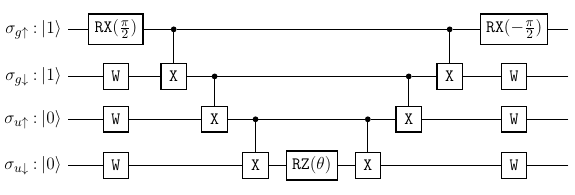

The $\mt{RX}(\frac{\pi}{2})$ and $\W$ gates rotate the basis such that the exponentiated operator applied to the corresponding qubit is either $\Y$ or $\X$, respectively. Single excitation terms are implemented with a change of basis.

6. Use qiskit to represent that circuit.

7. Use qiskit nature (VQE) to evaluate ground state of the Hydrogen molecule with the above *ansatz*.


In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table